# Speech Recognition with huggingface

Today we are going to explore speech recognition with huggingface transformers. There are many cool things about this example so let's jump right in.

First, huggingface datasets is a cool package which abstracts 2000+ datasets and makes them very easy to use. Soundfile is also a cool package which makes working with audio files in python very straightforward.

In [1]:
from transformers import Wav2Vec2Processor, Wav2Vec2ForCTC
from datasets import load_dataset
import soundfile as sf
import torch
import matplotlib.pyplot as plt
%matplotlib inline

## wav2vec2 

To recognize speech, huggingface leverages wav2vec2, which is a network developed by Facebook AI. 

![alt text](w2v2.png "wav2vec2")

wav2vec2 splits the problem of speech recognition into several parts:

1. Reduce the raw audio into a series of latent representations, then quantize those representations 
2. Put the qunatized representations into a transformer network to predict the transcriptions

For 1 above, wav2vec2 uses a strided CNN over a raw recorded waveform (left/right audio sampled at 16kHz) in conjunction with qunatization vectors and a linear projection. The quantized representations are then fed into a transformer network, allowing self-attention and reasoning between the quantized representations for a final prediction. 

__Note__ the picture above shows the self-supervised configuration of this neural network that was trained by Facebook AI for 1.6 days on 64 V100 GPUS. Essentially this process boils down to masking ~300mS of quantized speech, providing K + 1 options for the network to choose from (one matches the masked content and others do not), and expecting the network to select the correct option. This requires no labeled data; just a framework for generating the masks and the K distractors.

In [2]:
# load model and tokenizer
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-base-960h")

Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Next we load the dataset and a map function. A map function is applied to every example in the dataset, and allows a user to define a set of custom processing. For us, we will use the map function to read in the raw audio

In [3]:
# define function to read in sound file
def map_to_array(batch):
    speech, _ = sf.read(batch["file"])
    batch["speech"] = speech
    return batch

# load dataset and read soundfiles
ds = load_dataset("patrickvonplaten/librispeech_asr_dummy", "clean", split="validation")
ds = ds.map(map_to_array)

print('dataset has %d examples' % len(ds["speech"]))
print('dataset features')
print(ds.features)

Reusing dataset librispeech_asr (/home/john/.cache/huggingface/datasets/patrickvonplaten___librispeech_asr/clean/2.1.0/f2c70a4d03ab4410954901bde48c54b85ca1b7f9bf7d616e7e2a72b5ee6ddbfc)
Loading cached processed dataset at /home/john/.cache/huggingface/datasets/patrickvonplaten___librispeech_asr/clean/2.1.0/f2c70a4d03ab4410954901bde48c54b85ca1b7f9bf7d616e7e2a72b5ee6ddbfc/cache-80194e40350fb25b.arrow


dataset has 73 examples
dataset features
{'file': Value(dtype='string', id=None), 'audio': Audio(sampling_rate=16000, mono=True, _storage_dtype='string', id=None), 'text': Value(dtype='string', id=None), 'speaker_id': Value(dtype='int64', id=None), 'chapter_id': Value(dtype='int64', id=None), 'id': Value(dtype='string', id=None), 'speech': Sequence(feature=Value(dtype='float64', id=None), length=-1, id=None)}


# Raw audio to transcription

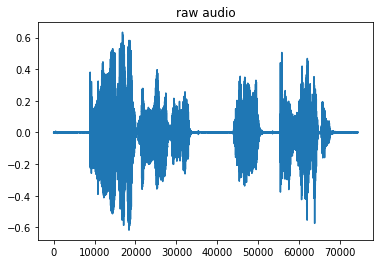

['A MAN SAID TO THE UNIVERSE SIR I EXIST', "SWEAT COVERED BRION'S BODY TRICKLING INTO THE TIGHT LOWING CLOTH THAT WAS THE ONLY GARMENT HE WORE"]


In [4]:
plt.plot(ds["speech"][:1][0])
plt.title("raw audio")
plt.show()
plt.clf()
plt.close()

# tokenize
input_values = processor(
    ds["speech"][:2], 
    return_tensors="pt", 
    padding="longest",
    sampling_rate=16000
).input_values  # Batch size 1

# retrieve logits
logits = model(input_values).logits

# take argmax and decode
predicted_ids = torch.argmax(logits, dim=-1)
transcription = processor.batch_decode(predicted_ids)

print(transcription)